### Benford's Law

According to the homonymous [Wikipedia page](https://en.wikipedia.org/wiki/Benford%27s_law#Examples): 

> **Benford's law**, is an observation that *in many real-life sets of numerical data, the leading digit is likely to be small*. In sets that obey the law, the number 1 appears as the leading significant digit about 30 % of the time, while 9 appears as the leading significant digit less than 5 % of the time. Note that, if the digits were distributed uniformly, they would each occur about 11.1 % of the time.

Below is a graphical representation of Benford's law: 

*Notice that the data used to populate the chart has been taken directly from the Wikipedia page using the `wikipedia` library (expand the cell below to see the relative code)*

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

#!pip install wikipedia
import wikipedia as wp
#wp.search('Benford')
page = wp.page("Benford")
html = page.html().encode("UTF-8")
bl = pd.read_html(html)[0]
bl.columns = ['ix', 'benford', 'to_drop']
bl.drop(columns=['to_drop'], inplace=True)
# remove % sign and convert to probability
bl['benford'] = bl['benford'].str.replace('%', '').astype('float')/100
#bl

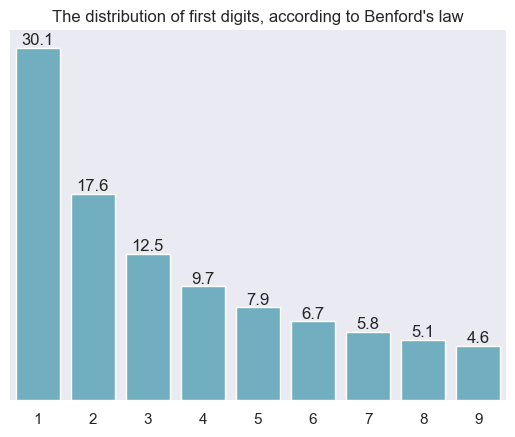

In [2]:
ax = sns.barplot(x=bl['ix'], y=bl['benford']*100, color='c')
ax.bar_label(ax.containers[0])
ax.get_yaxis().set_visible(False)
ax.set(xlabel=None)
ax.set(title='The distribution of first digits, according to Benford\'s law')
sns.despine(left=True, bottom=True)
plt.show()

As a first example, let's consider the following expression: 

$$
    \Bigl\{2^n\Bigl\}_{n=0}^{N} = \{2^0, 2^1, 2^2, 2^3, 2^4, ..., 2^{N}\}
$$ 

If we extract the first digit from each number resulting from the sequence, we should notice a very close adherence to Benford’s law. To demonstrate this fact we'll proceed in the following manner: 

1. Create a DataFrame `bl` that contains the theoretical values given by Benford's Law (we already have such DF from the code that generated the chart above); 
2. Generate the sequence $2^n$ for the first 100 integers (that is, $N=100$) and save them to a DataFrame named `two_n` having a `n` column containing the integer and a `2n` column containing the result of the expression; 
3. Extract the first digit from each element of the sequence and save it to a new column `2n_first_digit` in the `two_n` DataFrame; 
4. Generate a frequency table for all elements in the `two_n['2n_first_digit']`; 
5. Save the results to a new DataFrame named `two_n_freq`;
6. Merge the frequency table `two_n_freq` with the DataFrame containing the theoretical values of Benford's law `bl` and create a new DF `two_n_bl`; 
7. Plot the the density function of the two columns side by side; 
8. To get a single metric that tells us how close to the theoretical values of Benford's law our data is, let's compute an accuracy metric, technically known as the Mean Absolute Percentage Error (MAPE): 
    1. calculate the differences between the values of the frequency table and Benford's law theoretical values
    2. take the absolute values using `np.abs()`
    3. take the mean using `np.mean()`
    4. multiply by 100 to get a percentage

In [3]:
# 1. Create a DataFrame `bl` that contains the theoretical values given by Benford's Law
bl

,ix,benford
0,1,0.301
1,2,0.176
2,3,0.125
3,4,0.097
4,5,0.079
5,6,0.067
6,7,0.058
7,8,0.051
8,9,0.046


In [4]:
# 2. Generate the sequence 2^n for the first 100 integers (that is, N=100) and save them to a DataFrame named two_n;
two_n = pd.DataFrame({'n': range(0, 101),
                      '2n': [2**n for n in range(0, 101)]})
two_n.sample(5)

,n,2n
59,59,576460752303423488
47,47,140737488355328
5,5,32
19,19,524288
11,11,2048


In [5]:
# 3. Extract the first digit from each element of the sequence and save it to a new column `2n_first_digit` in the `two_n` DataFrame;
two_n['2n_first_digit'] = [int(str(el)[0]) for el in two_n['2n']]
two_n.sample(5)

,n,2n,2n_first_digit
64,64,18446744073709551616,1
14,14,16384,1
5,5,32,3
43,43,8796093022208,8
16,16,65536,6


In [6]:
# 4. Generate a frequency table for all elements in the two_n['2n_fd'];
two_n['2n_first_digit'].value_counts(normalize=True)

2n_first_digit
1    0.306931
2    0.168317
3    0.128713
4    0.099010
6    0.069307
5    0.069307
7    0.059406
8    0.049505
9    0.049505
Name: proportion, dtype: float64

In [7]:
# 5. Save the results to a new DataFrame named two_n_freq;
two_n_freq = pd.DataFrame({'ix': two_n['2n_first_digit'].value_counts(normalize=True).index,
                         'first_digit_freq': two_n['2n_first_digit'].value_counts(normalize=True).values})
two_n_freq

,ix,first_digit_freq
0,1,0.306931
1,2,0.168317
2,3,0.128713
3,4,0.099010
4,6,0.069307
5,5,0.069307
6,7,0.059406
7,8,0.049505
8,9,0.049505


In [8]:
# 6. Merge the frequency table (two_n_freq) with the DataFrame containing the theoretical values of Benford's law (bl)
#    and create a new DF `two_n_bl`
two_n_bl = two_n_freq.merge(bl, on='ix')
two_n_bl

,ix,first_digit_freq,benford
0,1,0.306931,0.301
1,2,0.168317,0.176
2,3,0.128713,0.125
3,4,0.099010,0.097
4,6,0.069307,0.067
5,5,0.069307,0.079
6,7,0.059406,0.058
7,8,0.049505,0.051
8,9,0.049505,0.046


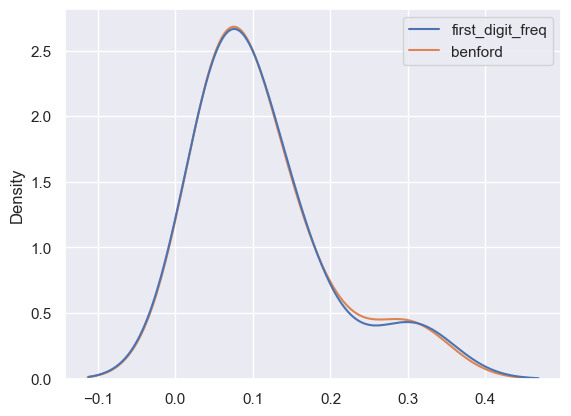

In [9]:
# 7. Plot the the density function of the two columns side by side;
sns.kdeplot(data=two_n_bl[['first_digit_freq', 'benford']])
plt.show()

In [10]:
# 8. To get a single metric that tells us how close to the theoretical values of Benford's law our data is,
#    let's compute an accuracy metric, technically known as the Mean Absolute Percentage Error (MAPE):
print('MAPE:', round(np.mean(np.abs(two_n_bl['first_digit_freq'] - two_n_bl['benford']))*100, 2), '%')

MAPE: 0.42 %


***

**Your turn!**

1. Check for Benford's Law in the `distance` variable from the `planets` dataset; in particular, make sure to produce: 
    1. A frequency table showing the number of occurrences for each first digit of the `distance` variable
    2. A chart showing two density plots comparing the data's frequency table and the theoretical values from Benford's law
    3. Print to screen an accuracy measure that summarises how well this data conforms to Benford's Law

In [11]:
df = sns.load_dataset('planets')
df.sample(5)

,method,number,orbital_period,mass,distance,year
294,Radial Velocity,1,388.00000,9.10,20.98,2005
1000,Transit,1,4.15914,NaN,200.00,2012
564,Radial Velocity,1,24.34800,0.72,19.89,1999
578,Radial Velocity,3,1931.00000,4.05,47.30,2009
573,Radial Velocity,2,613.80000,1.85,68.35,2010


In [12]:
#df['distance_fd'] = [int(str(el)[0]) for el in df.distance if np.isnan(el)==False]

df['distance_fd'] = [np.NaN if np.isnan(el) else int(str(el)[0]) for el in df['distance']]
df.sample(5)

,method,number,orbital_period,mass,distance,year,distance_fd
500,Radial Velocity,2,408.600000,2.24,68.54,2004,6.0
684,Transit,5,6.098493,NaN,290.00,2011,2.0
923,Microlensing,1,NaN,NaN,NaN,2009,NaN
775,Transit,1,9.434150,NaN,200.00,2013,2.0
780,Transit,1,17.815815,NaN,1107.00,2013,1.0


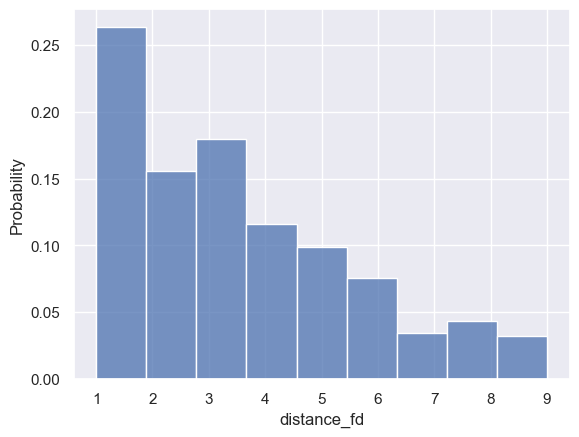

In [13]:
sns.histplot(df['distance_fd'], bins=9, stat='probability')
plt.show()

In [14]:
# 1A. A frequency table showing the number of occurrences for each first digit of the distance variable
freq_distance = pd.DataFrame({'ix': df['distance_fd'].value_counts(normalize=True).index,
                              'first_digit_freq': df['distance_fd'].value_counts(normalize=True).values})
freq_distance

,ix,first_digit_freq
0,1.0,0.263614
1,3.0,0.179455
2,2.0,0.155941
3,4.0,0.116337
4,5.0,0.099010
5,6.0,0.075495
6,8.0,0.043317
7,7.0,0.034653
8,9.0,0.032178


In [15]:
freq_distance_bl = freq_distance.merge(bl, on='ix')
freq_distance_bl

,ix,first_digit_freq,benford
0,1.0,0.263614,0.301
1,3.0,0.179455,0.125
2,2.0,0.155941,0.176
3,4.0,0.116337,0.097
4,5.0,0.099010,0.079
5,6.0,0.075495,0.067
6,8.0,0.043317,0.051
7,7.0,0.034653,0.058
8,9.0,0.032178,0.046


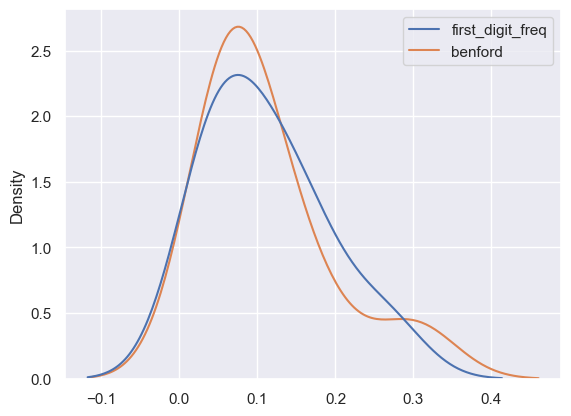

In [16]:
# 2B. A chart showing two density plots comparing the data's frequency table and the theoretical values from Benford's law
sns.kdeplot(data = freq_distance_bl[['first_digit_freq', 'benford']])
plt.show()

In [17]:
import plotly.express as px


freq_distance_bl['delta'] = freq_distance_bl['benford'] - freq_distance_bl['first_digit_freq']

fig = px.bar(freq_distance_bl,
base = "first_digit_freq",
x = "delta",
y = "ix",
orientation = 'h'
)

fig.update_yaxes(autorange="reversed")
fig.show()

In [18]:
# 3C. Print to screen an accuracy measure that summarises how well this data conforms to Benford's Law
print('MAPE:', round(np.mean(np.abs(freq_distance_bl['first_digit_freq'] - freq_distance_bl['benford']))*100, 2), '%')

MAPE: 2.27 %
